# sentinelsat

In [1]:
# see https://sentinelsat.readthedocs.io/en/stable/index.html
# and the Sentinel user guide at https://sentinels.copernicus.eu/web/sentinel/user-guides

#%pip install --user sentinelsat

In [2]:
# connect to the OData API
#
# save credentials for scihub.copernicus.eu in $HOME/.netrc like this:
#
# machine scihub.copernicus.eu
#   login <your username>
#   password <your password>
# machine colhub.met.no
#   login <your username>
#   password <your password>
#
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt, make_path_filter

local_api = SentinelAPI(None, None, "https://colhub-archive.met.no" ,timeout=180)
api = SentinelAPI(None, None, "https://scihub.copernicus.eu/dhus", timeout=180)

data_dir = "/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/"

In [3]:
# get full metadata for a specific product
api.get_product_odata('838f54c9-6255-4a1d-9bf7-d6dda743fd38', full=True)

{'id': '838f54c9-6255-4a1d-9bf7-d6dda743fd38',
 'title': 'S1A_IW_GRDH_1SDV_20181126T142233_20181126T142258_024760_02B976_067A',
 'size': 999808860,
 'md5': '032b30ffebe0f2e6d026f9cd77417f57',
 'date': datetime.datetime(2018, 11, 26, 14, 22, 33, 47000),
 'footprint': 'POLYGON((-122.421036 42.884716,-125.507095 43.278706,-125.175270 44.777348,-122.010872 44.383575,-122.421036 42.884716))',
 'url': "https://scihub.copernicus.eu/dhus/odata/v1/Products('838f54c9-6255-4a1d-9bf7-d6dda743fd38')/$value",
 'Online': True,
 'Creation Date': datetime.datetime(2018, 11, 26, 17, 20, 26, 716000),
 'Ingestion Date': datetime.datetime(2018, 11, 26, 17, 2, 46, 675000),
 'Acquisition Type': 'NOMINAL',
 'Carrier rocket': 'Soyuz',
 'Cycle number': 156,
 'Date': datetime.datetime(2018, 11, 26, 14, 22, 33, 47000),
 'Filename': 'S1A_IW_GRDH_1SDV_20181126T142233_20181126T142258_024760_02B976_067A.SAFE',
 'Footprint': '<gml:Polygon srsName="http://www.opengis.net/gml/srs/epsg.xml#4326" xmlns:gml="http://www.ope

In [4]:
# NOTE: Test data for api search

# Spatial locations
location = [3.4, 65.7]

# Time interval (would typically be one time interval for each observation point)
start_time = "2022-09-25T00:00:00.000Z"
end_time = "2022-09-26T23:59:59.000Z"

In [5]:
# import dict containing metadata for in-situ data
# https://raw.githubusercontent.com/jerabaul29/MachineOcean_WP1_WHOI/main/mo_whoi_data/data_files/in_situ_dict.py
# from private repo at https://github.com/jerabaul29/MachineOcean_WP1_WHOI
import time
import os

os.environ["TZ"] = "UTC"
time.tzset()

import datetime
import pytz

utc_timezone = pytz.timezone("UTC")

wd = os.getcwd()

os.chdir("../../MachineOcean_WP1_WHOI/mo_whoi_data/data_files")

import in_situ_dict
in_situ_obs = in_situ_dict.get_in_situ_metadata()

os.chdir(wd)

print(in_situ_obs.keys())

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])


In [24]:
# search by polygon, time, and SciHub query keywords - build dict with all relevant sat products, checking both scihub and local MET colhub

assert(False) # not necessary to do an SciHub search unless in_situ_obs is changed or appended - just read the pickle (see next cell)

products_colhub = {}
products_scihub = {}

print("Finding products with colocations for {} in-situ observation sites.".format(len(in_situ_obs)))


for site in in_situ_obs:
    location = [in_situ_obs[site]["lon"][0], in_situ_obs[site]["lat"][0]]
    start_time = in_situ_obs[site]["datetime_start"]
    end_time = in_situ_obs[site]["datetime_end"]
    
    footprint_json = {
    "type": "Feature",
    "geometry": {
        "type": "Point",
        "coordinates": location
      }
    }
    footprint = geojson_to_wkt(footprint_json)

    print("Searching {} from {} to {}...".format(footprint, start_time, end_time))

    # problems with colhub.met.no due to storeB maintanance
    #products_colhub.update(local_api.query(footprint,
    #                    date=(start_time, end_time),
    #                    platformname="Sentinel-1",
    #                    producttype="GRD"))
    #                    #limit=1,
    #                    #cloudcoverpercentage=(0, 30)))

    scihub_results = api.query(footprint,
                        date=(start_time, end_time),
                        platformname="Sentinel-1",
                        producttype="GRD")
                        #limit=1,
                        #cloudcoverpercentage=(0, 30))

    products_scihub.update(scihub_results)

    # attach scihub products to relevant in-situ obs site
    in_situ_obs[site]["products"] = scihub_results
    
    time.sleep(2) # scihub does not like too eager scripts...

print("Sat products available on colhub.met.no: " + str(len(products_colhub)))
print("Sat products available on scihub.copernicus.eu/dhus: " + str(len(products_scihub)))

Finding products with colocations for 18 in-situ observation sites.
Searching POINT(-124.3040 44.6393) from 2018-09-23 05:09:59.972136+00:00 to 2018-12-02 04:10:00.031061+00:00...
Searching POINT(-39.4738 59.9337) from 2020-08-18 00:12:00.037625+00:00 to 2021-07-31 23:11:59.960944+00:00...


Querying products:  33%|###2      | 100/305 [00:00<?, ?product/s]

Searching POINT(-125.0323 10.0508) from 2016-09-01 00:10:00.026599+00:00 to 2017-05-31 23:10:00.009211+00:00...
Searching POINT(-124.3040 44.6393) from 2016-10-05 00:10:00.000065+00:00 to 2017-01-22 16:09:59.977400+00:00...
Searching POINT(-39.4738 59.9337) from 2019-08-11 00:10:59.996491+00:00 to 2020-01-22 09:11:00.009255+00:00...


Querying products:  68%|######8   | 100/146 [00:00<?, ?product/s]

Searching POINT(-70.7785 40.1334) from 2016-05-13 13:10:00.019424+00:00 to 2016-10-15 20:10:00.006143+00:00...
Searching POINT(-65.0000 38.3180) from 2004-11-26 09:11:00.000001+00:00 to 2006-01-31 22:12:24.986109+00:00...
Searching POINT(-124.3040 44.6393) from 2019-04-20 00:09:59.997852+00:00 to 2019-06-07 05:10:00.001315+00:00...
Searching POINT(-70.7785 40.1334) from 2018-10-30 02:10:59.951061+00:00 to 2019-04-07 18:11:59.969933+00:00...
Searching POINT(-89.2069 -54.4041) from 2015-12-15 00:11:00.002254+00:00 to 2016-12-12 14:11:00.010032+00:00...
Searching POINT(-124.3040 44.6393) from 2016-05-17 20:12:00.011155+00:00 to 2016-09-24 23:10:00.015729+00:00...
Searching POINT(-70.7785 40.1334) from 2015-05-13 00:11:00.004044+00:00 to 2015-10-23 21:10:59.999860+00:00...
Searching POINT(-38.0000 24.5837) from 2012-09-14 23:09:59.999998+00:00 to 2013-09-30 08:14:00.000004+00:00...
Searching POINT(-124.3040 44.6393) from 2018-04-03 02:10:00.010519+00:00 to 2018-08-31 22:41:59.995723+00:00.

Querying products:  25%|##5       | 100/398 [00:00<?, ?product/s]

Searching POINT(-70.7785 40.1334) from 2017-06-09 13:11:00.017529+00:00 to 2017-10-31 23:12:00.016778+00:00...
Searching POINT(-70.7785 40.1334) from 2016-10-13 16:10:59.961273+00:00 to 2017-06-09 15:12:00.002834+00:00...
Searching POINT(-70.7785 40.1334) from 2017-11-01 00:10:59.969725+00:00 to 2018-03-29 18:10:59.991170+00:00...
Sat products available on colhub.met.no: 0
Sat products available on scihub.copernicus.eu/dhus: 1054


In [37]:
# pickle imported in-situ measurements metadata with attached colocated Sentinel-1 sat products metadata
# (to avoid having to rerun the API search)
import pickle

assert(False) # do not run, unless the search in the previous cell has been run
with open('in_situ_obs.pickle', 'wb') as handle:
    pickle.dump(in_situ_obs, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('products_scihub.pickle', 'wb') as handle:
    pickle.dump(products_scihub, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

In [6]:
# read pickled imported in-situ measurements metadata with attached colocated Sentinel-1 sat products metadata
# (to avoid having to rerun the API search)
import pickle

with open('in_situ_obs.pickle', 'rb') as handle:
    in_situ_obs = pickle.load(handle)

with open('products_scihub.pickle', 'rb') as handle:
    products_scihub = pickle.load(handle)

In [7]:
print(in_situ_obs.keys())

# for each in_situ_obs timeseries, collocated sat products are found as a dict in "products"
import pprint 
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(in_situ_obs['Pioneer_7']["products"]["7e1d1641-af53-4486-bb45-8411c61d1aba"])

dict_keys(['Endurance_8', 'Irminger_7', 'SPURS2', 'Endurance_4', 'Irminger_6', 'Pioneer_5', 'CLIMODE', 'Endurance_9', 'Pioneer_10', 'SouthernOcean2', 'Endurance_3', 'Pioneer_3', 'SPURS1', 'Endurance_7', 'Irminger_3', 'Pioneer_7', 'Pioneer_6', 'Pioneer_8'])
{   'acquisitiontype': 'NOMINAL',
    'beginposition': datetime.datetime(2017, 10, 22, 22, 42, 24, 875000),
    'endposition': datetime.datetime(2017, 10, 22, 22, 42, 49, 874000),
    'filename': 'S1A_IW_GRDH_1SDV_20171022T224224_20171022T224249_018932_01FFE8_5D27.SAFE',
    'footprint': 'POLYGON ((-73.116463 40.464302,-70.097900 '
                 '40.865818,-69.783722 39.365147,-72.736824 '
                 '38.962429,-73.116463 40.464302))',
    'format': 'SAFE',
    'gmlfootprint': '<gml:Polygon '
                    'srsName="http://www.opengis.net/gml/srs/epsg.xml#4326" '
                    'xmlns:gml="http://www.opengis.net/gml">\n'
                    '   <gml:outerBoundaryIs>\n'
                    '      <gml:LinearRing>\n

Endurance_8 has 13 colocations
Irminger_7 has 305 colocations
SPURS2 has 0 colocations
Endurance_4 has 21 colocations
Irminger_6 has 146 colocations
Pioneer_5 has 6 colocations
CLIMODE has 0 colocations
Endurance_9 has 12 colocations
Pioneer_10 has 37 colocations
SouthernOcean2 has 0 colocations
Endurance_3 has 10 colocations
Pioneer_3 has 10 colocations
SPURS1 has 0 colocations
Endurance_7 has 28 colocations
Irminger_3 has 398 colocations
Pioneer_7 has 16 colocations
Pioneer_6 has 28 colocations
Pioneer_8 has 25 colocations
Total no of sat products: 1055


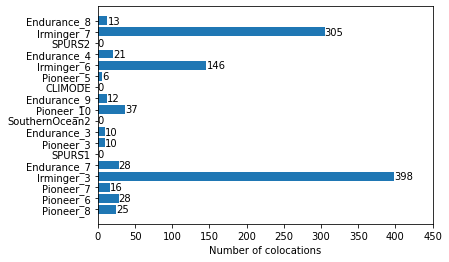

In [8]:
# how many colocations do we have? 
# (*assuming that there always are temporal colocations to be found as long as sat product is within in-situ obs start-end time interval)

sites = []
n_colocations = []
total_n_colocations = 0

for name, obs in in_situ_obs.items():
    sites.append(name)
    n = len(obs["products"].keys())
    n_colocations.append(n)
    total_n_colocations += n
    print("{} has {} colocations".format(name, n))

print("Total no of sat products: {}".format(total_n_colocations))

# visualize
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

y_pos = np.arange(len(sites))

hbars = ax.barh(y_pos, n_colocations, align='center')
ax.set_yticks(y_pos, labels=sites)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel("Number of colocations")

# Label with specially formatted floats
ax.bar_label(hbars, fmt='%i')
ax.set_xlim(right=450)  # adjust xlim to fit labels

plt.show()

In [9]:
# are the products online or offline?
online = 0
offline = 0

assert(False)
for product_id in list(products_scihub.keys()):
    if api.is_online(product_id):
        online += 1
    else:
        offline += 1

print("{} online products and {} offline products available on scihub.".format(online, offline))

AssertionError: 

From https://forum.step.esa.int/t/esa-copernicus-data-access-long-term-archive-and-its-drawbacks/15394 

[…] you try an bypass the quota restrictions by using multiple user accounts to access large volumes of data products from the LTA. Please note that the maximum number of products that a single user can request on SciHub is 1 every 30 minutes. An additional quota limit is applied to users of the APIHub of maximum 20 products every 12 hours. These restrictions are dictated by ESA and unless they change their policy then users will have to follow these guidelines. […]

Base on the long time archive (LTA) quota: 1000 products / 40 products per day = 25 days (not taking download time into account)

In [10]:
# convert to Pandas DataFrame
products_df = api.to_dataframe(products_scihub)

# GeoJSON FeatureCollection containing footprints and metadata of the scenes
products_geojson = api.to_geojson(products_scihub)

# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
products_gdf = api.to_geodataframe(products_scihub)

In [11]:
products_gdf

,title,link,link_alternative,link_icon,summary,ondemand,ingestiondate,beginposition,endposition,missiondatatakeid,...,polarisationmode,productclass,producttype,platformname,size,status,timeliness,uuid,processed,geometry
838f54c9-6255-4a1d-9bf7-d6dda743fd38,S1A_IW_GRDH_1SDV_20181126T142233_20181126T1422...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-26T14:22:33.047Z, Instrument: SA...",false,2018-11-26 17:02:46.675,2018-11-26 14:22:33.047,2018-11-26 14:22:58.046,178550,...,VV VH,S,GRD,Sentinel-1,1.59 GB,ARCHIVED,Fast-24h,838f54c9-6255-4a1d-9bf7-d6dda743fd38,NaN,"POLYGON ((-122.42104 42.88472, -125.50710 43.2..."
7b3ee3cd-8860-49d2-b08b-3aac8e4873b4,S1B_IW_GRDH_1SDV_20181122T020852_20181122T0209...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-22T02:08:52.289Z, Instrument: SA...",false,2018-11-22 13:11:08.195,2018-11-22 02:08:52.289,2018-11-22 02:09:17.286,104022,...,VV VH,S,GRD,Sentinel-1,1.62 GB,ARCHIVED,Fast-24h,7b3ee3cd-8860-49d2-b08b-3aac8e4873b4,NaN,"POLYGON ((-125.82740 45.27129, -122.55980 45.6..."
9a7be3d5-e1b8-44c4-a3d4-7d59b1d38d9e,S1A_IW_GRDH_1SDV_20181114T142233_20181114T1422...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-14T14:22:33.478Z, Instrument: SA...",false,2018-11-14 17:10:45.400,2018-11-14 14:22:33.478,2018-11-14 14:22:58.477,176903,...,VV VH,S,GRD,Sentinel-1,1.59 GB,ARCHIVED,Fast-24h,9a7be3d5-e1b8-44c4-a3d4-7d59b1d38d9e,NaN,"POLYGON ((-122.42115 42.88469, -125.50721 43.2..."
ebb185b2-cfc6-41f5-8bb7-042bbb781a0e,S1B_IW_GRDH_1SDV_20181113T142953_20181113T1430...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-13T14:29:53.626Z, Instrument: SA...",false,2018-11-13 19:10:59.890,2018-11-13 14:29:53.626,2018-11-13 14:30:18.626,103028,...,VV VH,S,GRD,Sentinel-1,1.6 GB,ARCHIVED,Fast-24h,ebb185b2-cfc6-41f5-8bb7-042bbb781a0e,NaN,"POLYGON ((-124.28217 43.59385, -127.43363 43.9..."
9847018a-bbbd-468a-b466-410f60477a88,S1A_IW_GRDH_1SDV_20181102T142233_20181102T1422...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2018-11-02T14:22:33.779Z, Instrument: SA...",false,2018-11-02 17:09:09.321,2018-11-02 14:22:33.779,2018-11-02 14:22:58.778,175259,...,VV VH,S,GRD,Sentinel-1,1.59 GB,ARCHIVED,Fast-24h,9847018a-bbbd-468a-b466-410f60477a88,NaN,"POLYGON ((-122.42085 42.88464, -125.50678 43.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
01a8bd84-fb65-49f5-86ee-9da8daf05054,S1A_IW_GRDH_1SDV_20171127T224224_20171127T2242...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2017-11-27T22:42:24.293Z, Instrument: SA...",false,2017-11-28 04:09:29.508,2017-11-27 22:42:24.293,2017-11-27 22:42:49.291,135219,...,VV VH,S,GRD,Sentinel-1,1.61 GB,ARCHIVED,NaN,01a8bd84-fb65-49f5-86ee-9da8daf05054,NaN,"POLYGON ((-73.11754 40.46411, -70.09877 40.865..."
a4aaccb8-e659-4f42-8a51-1560ee658210,S1B_IW_GRDH_1SDV_20171127T104840_20171127T1049...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,https://scihub.copernicus.eu/dhus/odata/v1/Pro...,"Date: 2017-11-27T10:48:40.37Z, Instrument: SAR...",false,2017-11-27 13:40:32.181,2017-11-27 10:48:40.370,2017-11-27 10:49:05.814,61453,...,VV VH,S,GRD,Sentinel-1,1.6 GB,ARCHIVED,NaN,a4aaccb8-e659-4f42-8a51-1560ee658210,NaN,"POLYGON ((-69.75826 39.70948, -72.67251 40.102..."
1ce1dd81-8eb4-4b5f-9eef-ec530a375f59,S1A_IW_GRDH_1SDV_20171115T22

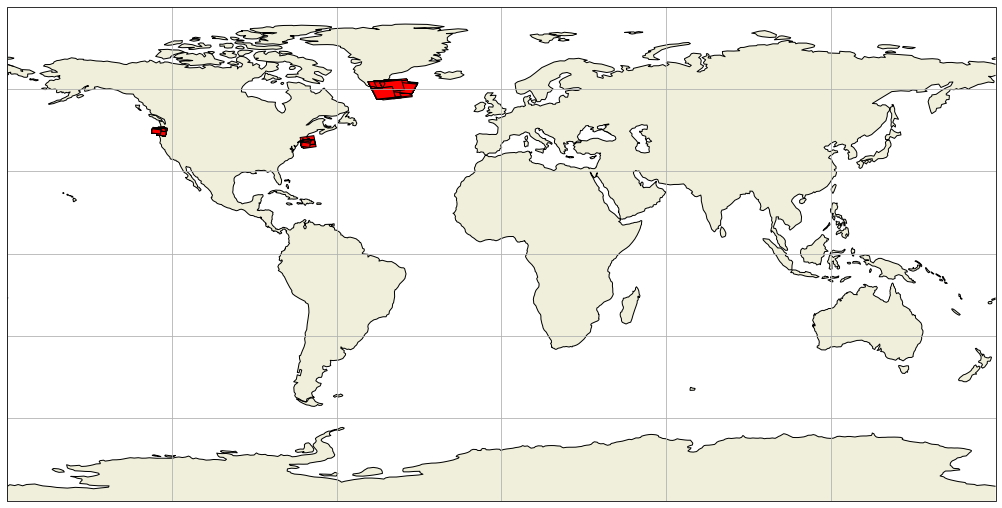

In [12]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt

import numpy as np

fig = plt.figure(figsize=(20, 20))

bounds = products_gdf.total_bounds

ax1 = plt.subplot(2, 1, 1, projection=ccrs.PlateCarree())
ax1.gridlines()
ax1.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
ax1.add_feature(cfeature.LAND)
ax1.add_feature(cfeature.COASTLINE)

#ax2 = plt.subplot(2, 1, 2, projection=ccrs.PlateCarree())
#ax2.add_geometries(products_gdf.geometry, crs = ccrs.PlateCarree(), facecolor='red', edgecolor='k')
#ax2.set_extent([bounds[0], bounds[2], bounds[1], bounds[3]], ccrs.PlateCarree())
#ax2.add_feature(cfeature.LAND)
#ax2.add_feature(cfeature.COASTLINE)
#
#locations_np = np.array(locations)
#locs_x, locs_y = locations_np.T
#ax2.scatter(locs_x, locs_y, transform=ccrs.PlateCarree(), zorder=2)

plt.show()

In [13]:
#path_filter = make_path_filter("*s1?-*-grd-*.tiff") # all Sentinel 1 GRD products
#api.download_all(products_scihub, directory_path=data_dir)#, nodefilter=path_filter)

# 1st step: Download all Pioneer colocated products
download_products = {}

assert(False)
for name, obs in in_situ_obs.items():
    if "Pioneer" in name:
        print("Downloading {} products containing colocations with {}...".format(len(obs["products"].keys()), name), end="")
        api.download_all(obs["products"], directory_path=data_dir)
        print("done")

AssertionError: 

In [14]:
import zipfile
from os import path

# unzip all downloaded products
for product_name in products_gdf.title:
    zip_filename = data_dir + "{}.zip".format(product_name)
    safe_dir_name = data_dir + "{}.SAFE".format(product_name)

    if path.exists(zip_filename) and not path.exists(safe_dir_name):
        with zipfile.ZipFile(zip_filename,"r") as zip_ref:
            zip_ref.extractall(data_dir)

In [15]:
# Clone nansat and add to $PYTHONPATH
#!git clone git@github.com:nansencenter/nansat.git
import sys
sys.path.append("../../nansat/")
from nansat import Nansat

# (might have to compile some code in Nansat, see warning when importing from nansat)
# (in nansat root dir: python setup.py build_ext --inplace)

# Install nansat dependency (not found in conda env production-10-2022)
#%pip install --user pythesint

# if you are running on you own laptop you will also need to do:
#!sudo apt-get install libgdal-dev
#!pip install --user GDAL==$(gdal-config --version | awk -F'[.]' '{print $1"."$2}')

# list a SAR product with Nansat
n = Nansat(data_dir + "S1A_IW_GRDH_1SDV_20220925T171246_20220925T171311_045164_0565E1_358E.SAFE")
print(n)


/lustre/storeB/users/martinls/src/machine-ocean-satdata/notebooks/../../nansat/nansat/nansat.py:1125: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if mappername is not '':
/lustre/storeB/users/martinls/src/machine-ocean-satdata/notebooks/../../nansat/nansat/mappers/mapper_obpg_l2.py:57: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if title is 'GOCI Level-2 Data':
/lustre/storeB/users/martinls/src/machine-ocean-satdata/notebooks/../../nansat/nansat/mappers/mapper_obpg_l2.py:202: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if title is 'GOCI Level-2 Data':


/home/martinls/.local/share/pythesint/json


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gcmd.earthdata.nasa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


/home/martinls/.local/share/pythesint/json


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gcmd.earthdata.nasa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


/home/martinls/.local/share/pythesint/json


/usr/lib/python3/dist-packages/urllib3/connectionpool.py:999: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gcmd.earthdata.nasa.gov'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  warnings.warn(


/home/martinls/.local/share/pythesint/json
----------------------------------------
/lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/S1A_IW_GRDH_1SDV_20220925T171246_20220925T171311_045164_0565E1_358E.SAFE----------------------------------------
Mapper: sentinel1_l1Band : 1 DN_VV
  dataType: 2
  name: DN_VV
  SourceBand: 1
  SourceFilename: /lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/S1A_IW_GRDH_1SDV_20220925T171246_20220925T171311_045164_0565E1_358E.SAFE/measurement/s1a-iw-grd-vv-20220925t171246-20220925t171311-045164-0565e1-001.tiff
Band : 2 DN_VH
  dataType: 2
  name: DN_VH
  SourceBand: 1
  SourceFilename: /lustre/storeB/project/IT/geout/machine-ocean/data_raw/sentinel/S1A_IW_GRDH_1SDV_20220925T171246_20220925T171311_045164_0565E1_358E.SAFE/measurement/s1a-iw-grd-vh-20220925t171246-20220925t171311-045164-0565e1-002.tiff
Band : 3 sigmaNought_VV
  dataType: 7
  name: sigmaNought_VV
  SourceBand: 1
  SourceFilename: /vsimem/H052LTB79W.vrt
Band : 4 no

Variable              Type                 Data/Info
----------------------------------------------------
Nansat                type                 <class 'nansat.nansat.Nansat'>
SentinelAPI           type                 <class 'sentinelsat.sentinel.SentinelAPI'>
api                   SentinelAPI          <sentinelsat.sentinel.Sen<...>object at 0x7fbf106cf550>
ax                    AxesSubplot          AxesSubplot(0.125,0.125;0.775x0.755)
ax1                   GeoAxesSubplot       < GeoAxes: +proj=eqc +ell<...>er=1 +no_defs +type=crs >
b1                    ndarray              16678x26499: 441950322 elems, type `uint16`, 883900644 bytes (842.9533424377441 Mb)
bounds                ndarray              4: 4 elems, type `float64`, 32 bytes
ccrs                  module               <module 'cartopy.crs' fro<...>packages/cartopy/crs.py'>
cfeature              module               <module 'cartopy.feature'<...>opy/feature/__init__.py'>
data_dir              str                  /lustre/

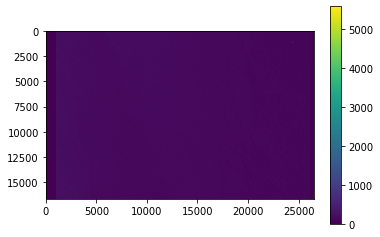

In [16]:
# plot a SAR product with Nansat
b1 = n[1]

%whos
plt.imshow(b1);plt.colorbar()
plt.show()

# write to file
#n.write_figure('map.png', pltshow=True)

In [ ]:
sys.path.append("..")
import sar

# plot a normalize SAR product
# NOTE: This crashes the python kernel, and I do not know why. I have tested on PPI and my laptop (Python 3.8.10), 
# both in a Jupyter notebook and directly in the Python shell.
norm_b1 = sar.sar_params(data_dir + "S1A_IW_GRDH_1SDV_20220925T171246_20220925T171311_045164_0565E1_358E.SAFE", 1.5, 65.0)

#plt.imshow(norm_b1)
#plt.colorbar()
#plt.show()